# 1. Imports

In [98]:
# importing other dependencies
import numpy as np
import pandas as pd
# importing PyTorch
import torch
# importing torch.nn Module
import torch.nn as nn
# to load the activation functions
import torch.nn.functional as F
# importing Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader, TensorDataset
# create datasets using `ImageFolder`
from torchvision.datasets import ImageFolder
# import compose and other transformations
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, ToTensor, Resize, CenterCrop
# plotting
import matplotlib.pyplot as plt


# for file paths
import os
# for time
import time
# for copying
import copy

In [99]:
# checks whether MPS is available
print(torch.backends.mps.is_available())

# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

# setting the device to "mps" instead of default "cpu"
device = torch.device("mps" if torch.backends.mps.is_available else "cpu")

True
True


In [100]:
# training on GPU
device

device(type='mps')

# 2. Preparing Data

In this particular notebook, we want to build a ants vs bees classsifier using transfer learning.

We have custom downloaded images of ants and bees. We use these images to train our classifier. We turn these into PyTorch `datasets` objects using `ImageFolder` module in PyTorch.

The folder structure should be as follows:
```
 root
├── train
│   ├── ants
│   │   └── ants_image1.png
│   │   └── ants_image2.png
│   ├── bees
│   │   └── bees_image1.png
│   │   └── bees_image1.png
├── test
│   ├── ants
│   │   └── ants_image1.png
│   │   └── ants_image1.png
│   ├── bees
│   │   └── bees_image1.png
│   │   └── bees_image1.png
│   │
│
```

Since, we are going to be raw images crawled from internet, we apply a few transformations before they are usable. In this scenario we want to keep our images `[3,224,224]` dimensional across all the data. This is because we will be using  the pre-trained `ResNet-18` classifier by keeping the initial layers the same and only by changing the FCC layers. We can do this task in 2 ways, both of which will be shown below.

In [101]:
# defining the composite transforms from train and test
# we define these together in a form of dictionary

from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, Resize, CenterCrop, ToTensor, Normalize

# we want the pixel values in each individual channel to have a value between 0 and 1, with a mean of 0.5 and std dev of 0.25 across channels.
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    # train transform
    'train': Compose([
        RandomResizedCrop(224),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize(mean, std)
    ]),
    # validation transform
    'val': Compose([
        Resize(256),
        RandomResizedCrop(224),
        ToTensor(),
        Normalize(mean, std)
    ]),
    # test transform
    'test': Compose([
        Resize(256),
        RandomResizedCrop(224),
        ToTensor(),
        Normalize(mean, std)
    ])
}

In [102]:
data_dir = os.path.join('data','ants_vs_bees')
data_dir

'data/ants_vs_bees'

In [103]:
# some hyper-parameters
batch_size = 5
num_epochs = 10
learning_rate = 0.001

In [104]:
# create datasets using `ImageFolder`

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

image_datasets = {x:ImageFolder(root= os.path.join(data_dir, x), transform=data_transforms[x])
                for x in ['train', 'val', 'test']}

image_dataloaders = {'train':DataLoader(
                        dataset=image_datasets['train'],
                        batch_size=batch_size,
                        shuffle=True,
                    ),
                     'val':DataLoader(
                        dataset=image_datasets['val'],
                        batch_size=len(image_datasets['val']),
                        shuffle=True,
                    ),
                     'test':DataLoader(
                        dataset=image_datasets['test'],
                        batch_size=len(image_datasets['test']),
                        shuffle=True,
                    )}

data_sizes = {x:len(image_datasets[x])
                for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes
print("Class Names:", class_names)

Class Names: ['ants', 'bees']


Let's analyse the data.

In [105]:
# extracting the test dataset
X_test, y_test = next(iter(image_dataloaders['test']))
# move the data to GPU
X_test, y_test = X_test.to(device), y_test.to(device)
# print the shape
print(X_test.shape, y_test.shape)

torch.Size([113, 3, 224, 224]) torch.Size([113])


So, we have `113` examples in our test set, which are `224*224` triple-channeled colored images. We try visualizing these images:

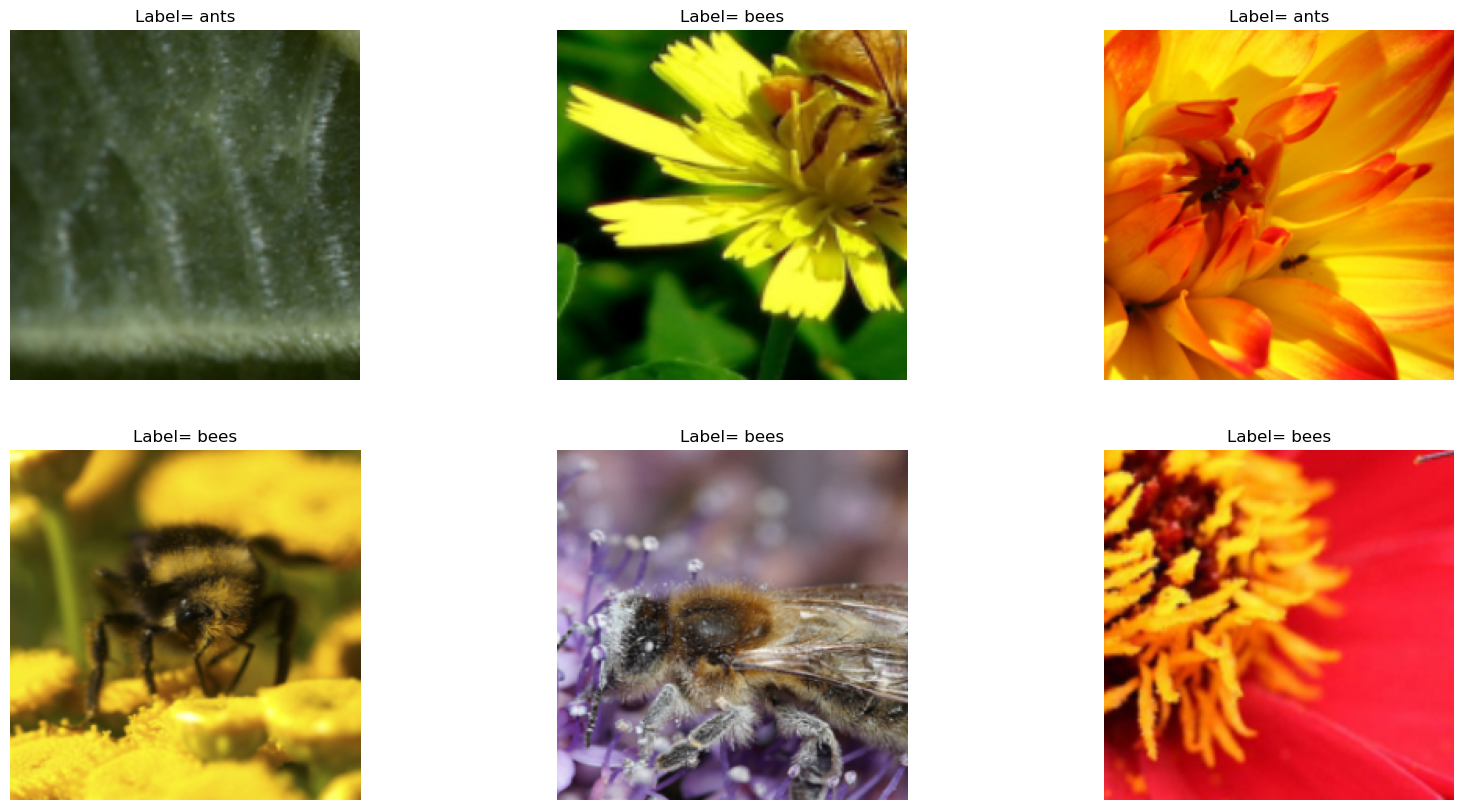

In [106]:
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    # copy the image back to cpu to reshape
    img = X_test[i].cpu()
    # we have multi-channel image
    # pre-precoss the image before printing
    img = np.transpose(img, (1,2,0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.title("Label= " + class_names[y_test[i]])
    plt.grid(False)
    plt.axis(False)
plt.show()

# 3. Training

This time we are setting up a custom training method to carry out the training process for different models.

In [107]:
from sklearn.metrics import accuracy_score

def train_model(model, criterion, optimizer, scheduler=None, num_epochs=20):
    # begin start time to record time-elapsed
    # since = time.time()

    # to return the model with best accuracy
    # variable to store the best model parameters
    best_model_params = copy.deepcopy(model.state_dict())
    # variable to store the best accuracy
    best_acc = 0.0

    # start training epochs
    for epoch in range(num_epochs):

        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase=='train':
                model.train() # set model to training mode
            else:
                model.eval() # set model to evaluate mode
            
            # iterate over data
            for batch in image_dataloaders[phase]:
                # extract features and labels
                X,y = batch
                # adding to GPU
                X,y = X.to(device), y.to(device)

                # forward
                # track grad iff phase == train
                with torch.set_grad_enabled(phase=='train'):
                    # compute prediction
                    y_pred = model(X)

                    # loss + backward + optimize iff phase = 'train'
                    if phase=='train':
                        # compute loss
                        loss = criterion(y_pred, y)
                        # compute grads
                        loss.backward()
                        # update weights
                        optimizer.step()
                        # zero-gradients after updating
                        optimizer.zero_grad()
                
            # learning scheduler step iff phase == 'train'
            if scheduler and phase=='train':
                # update learning rate
                scheduler.step()
            
            # check accuracy on validation set iff phase == 'val'
            if phase=='val':
                _, y_hat = torch.max(y_pred, dim=1)
                epoch_acc = accuracy_score(y.cpu(), y_hat.cpu())

        # update best_model and best accuracy after the epoch
        if epoch_acc >= best_acc:
            best_acc = epoch_acc
            best_model_params = copy.deepcopy(model.state_dict())
        
        # print epoch info
        print('-----------------------------------------')
        print('Epoch: {}/{}'.format(epoch+1, num_epochs))
        print('Best Val Acc: {:2f}'.format(best_acc))
        # to keep track of time
        '''
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        '''
    

    # post training, load the best_model parameters and output the model

    # load best model weights
    model.load_state_dict(best_model_params)
    return model


# 4. Model

In this example, we use the pre-trained `ResNet-18` model. We do this in 2 ways:
- **Model 1:** Here we load the pre-trained `ResNet-18` and reset the last FC (Fully Connected) layer and re-train the model with our training set. This is slower than Method 2.
- **Model 2:** Here, we again load the pre-trained `ResNet-18` and freeze all the layers except the last FC layer. We use the Conv Net as a feature extractor. We tune the final layer by re-training the model on the training set. This is faster than Method 1.

## 4.1 Model-1

Here we load the pre-trained `ResNet-18` and reset the last FC (Fully Connected) layer and re-train the model with our training set. This is slower.

Here, the last fully-connected layer can be accessed by calling `model.fc`.


In [108]:
from torchvision import models

model1 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# extract the input features taken in by the last FC layer
fc_inp_size = model1.fc.in_features
# reset the fc layer
model1.fc = nn.Linear(fc_inp_size, len(class_names))

In [109]:
# define parameters for training

# add model to GPU
model = model1.to(device)

# define loss
criterion = nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr = learning_rate
)

# step Learning Rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer,
    step_size=10,
    gamma=0.5
)

Let's check the performance of the model on the test data.

In [110]:
# we also check the initial accuracy on the test data before training

from sklearn.metrics import accuracy_score

with torch.no_grad():
    # this gives the sigmoid output
    y_test_pred = model(X_test)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)
    # push the matrices back to cpu from gpu
    y_test_hat_cpu = y_test_hat.cpu()
    y_test_cpu = y_test.cpu()
    print("Initial Accuracy on test data:", accuracy_score(y_test_cpu, y_test_hat_cpu))

Initial Accuracy on test data: 0.4690265486725664


### Training

In [111]:
model = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=30,
)

-----------------------------------------
Epoch: 1/30
Best Val Acc: 0.700000
-----------------------------------------
Epoch: 2/30
Best Val Acc: 0.700000
-----------------------------------------
Epoch: 3/30
Best Val Acc: 0.700000
-----------------------------------------
Epoch: 4/30
Best Val Acc: 0.700000
-----------------------------------------
Epoch: 5/30
Best Val Acc: 0.700000
-----------------------------------------
Epoch: 6/30
Best Val Acc: 0.700000
-----------------------------------------
Epoch: 7/30
Best Val Acc: 0.700000
-----------------------------------------
Epoch: 8/30
Best Val Acc: 0.700000
-----------------------------------------
Epoch: 9/30
Best Val Acc: 0.700000
-----------------------------------------
Epoch: 10/30
Best Val Acc: 0.700000
-----------------------------------------
Epoch: 11/30
Best Val Acc: 0.700000
-----------------------------------------
Epoch: 12/30
Best Val Acc: 0.700000
-----------------------------------------
Epoch: 13/30
Best Val Acc: 0.70

### Evaluation

Let's check the performance of the model on the test data after training.

In [112]:
# we also check the final accuracy on the test data after training

from sklearn.metrics import accuracy_score

with torch.no_grad():
    # this gives the sigmoid output
    y_test_pred = model(X_test)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)
    # push the matrices back to cpu from gpu
    y_test_hat_cpu = y_test_hat.cpu()
    y_test_cpu = y_test.cpu()
    print("Final Accuracy on test data:", accuracy_score(y_test_cpu, y_test_hat_cpu))

Final Accuracy on test data: 0.6194690265486725


# 4.2 Model-2

Here, we again load the pre-trained `ResNet-18` and freeze all the layers except the last FC layer. We use the Conv Net as a feature extractor. We tune the final layer by re-training the model on the training set. This is faster.

In [126]:
from torchvision import models

model2 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# freeze all the layers except the final FC Layer
for params in model2.parameters():
    params.requires_grad=False

# parameters of newly constructed modules have `required_grad=True` by default
# extract the input features taken in by the last FC layer
fc_inp_size = model2.fc.in_features
# reset the fc layer
model2.fc = nn.Linear(fc_inp_size, len(class_names))

In [127]:
# define parameters for training

# add model to GPU
model = model2.to(device)

# define loss
criterion = nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr = learning_rate,
    momentum=0.9
)

# step Learning Rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer,
    step_size=10,
    gamma=0.5
)

Let's check the performance of the model on the test data.

In [128]:
# we also check the initial accuracy on the test data before training

from sklearn.metrics import accuracy_score

with torch.no_grad():
    # this gives the sigmoid output
    y_test_pred = model(X_test)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)
    # push the matrices back to cpu from gpu
    y_test_hat_cpu = y_test_hat.cpu()
    y_test_cpu = y_test.cpu()
    print("Initial Accuracy on test data:", accuracy_score(y_test_cpu, y_test_hat_cpu))

Initial Accuracy on test data: 0.4424778761061947


### Training

In [129]:
model = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=30,
)

-----------------------------------------
Epoch: 1/30
Best Val Acc: 0.862500
-----------------------------------------
Epoch: 2/30
Best Val Acc: 0.887500
-----------------------------------------
Epoch: 3/30
Best Val Acc: 0.887500
-----------------------------------------
Epoch: 4/30
Best Val Acc: 0.912500
-----------------------------------------
Epoch: 5/30
Best Val Acc: 0.925000
-----------------------------------------
Epoch: 6/30
Best Val Acc: 0.925000
-----------------------------------------
Epoch: 7/30
Best Val Acc: 0.925000
-----------------------------------------
Epoch: 8/30
Best Val Acc: 0.937500
-----------------------------------------
Epoch: 9/30
Best Val Acc: 0.937500
-----------------------------------------
Epoch: 10/30
Best Val Acc: 0.937500
-----------------------------------------
Epoch: 11/30
Best Val Acc: 0.937500
-----------------------------------------
Epoch: 12/30
Best Val Acc: 0.937500
-----------------------------------------
Epoch: 13/30
Best Val Acc: 0.93

### Evaluation

Let's check the performance of the model on the test data after training.

In [130]:
# we also check the final accuracy on the test data after training

from sklearn.metrics import accuracy_score

with torch.no_grad():
    # this gives the sigmoid output
    y_test_pred = model(X_test)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)
    # push the matrices back to cpu from gpu
    y_test_hat_cpu = y_test_hat.cpu()
    y_test_cpu = y_test.cpu()
    print("Final Accuracy on test data:", accuracy_score(y_test_cpu, y_test_hat_cpu))

Final Accuracy on test data: 0.8938053097345132
